In [ ]:
#################
# INSTALACIONES #
#################

!pip install datasets
!pip install Transformers
!pip install evaluate
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 39.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
####################################
# CARGA FICHERO DESDE GOOGLE DRIVE #
####################################

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import pandas as pd
pd.set_option('display.max_rows', None)
# Fichero preparado con textos únicos y con 1 ó más de 1 keyword asignada, separada por comas
# Eliminados previamente Outliers superiores (longitud título > 80)
df = pd.read_csv('/content/gdrive/MyDrive/TFM/ofertas2022_preClean.csv')
dfOriginal= df

Mounted at /content/gdrive


In [ ]:
###################################
# FUNCIÓN PARA ELIMINAR STOPWORDS #
###################################

# SE EVITA ELIMINACIÓN DE STOPWORDS POR TIPO DE ALGORITMO

#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')

#def eliminarStopWordsTexto(texto):
  # En la librería hay 313 stopwords en castellano
#  stopWords = set(stopwords.words('spanish'))
  # Tokenizado/parseo
#  words = word_tokenize(texto)
  # Sólo se anotan las que no están en la lista de stopWords
#  salida = [w for w in words if not w in stopWords]
  # Se devuelve en formato de texto
#  return ' '.join(salida)


In [ ]:
########################
# FUNCIÓN LEMATIZACIÓN #
########################

# SE EVITA LEMITACIÓN POR TIPO DE ALGORITMO

#import spacy
#nlp = spacy.load('es_core_news_sm') # Basado en noticias en castellano

#def lematizarTexto(texto): # es accent-sensitive
#  words = nlp(texto)
#  salida = [w.lemma_ for w in words]
#  return ' '.join(salida)

In [ ]:
###############################
# FUNCIÓN PARA LIMPIAR TEXTOS #
###############################

from gensim.utils import deaccent
import re # expresiones regulares

def limpiarTexto(texto): 
  texto = texto.lower()                                                         # todo a minúsculas
  texto = texto.replace('os/as', 'os').replace('o/a', 'o').replace('r/a', 'r')  # unifica género
  texto = texto.replace('i+d', 'investigacion desarrollo')                      # acrónimo desambiguado (muy usual) Existen modelos que lo hacen (p.ej: ABB-BERT)
  texto = texto.replace('(h/m/d)', '').replace('(h/m/x)', '')                   # marcas no discriminación por genero
  texto = texto.replace('(m/f)', '').replace('(m/f)', '')                       # marcas no discriminación por genero
  # SE EVITA LEMITACIÓN POR TIPO DE ALGORITMO
  # texto = eliminarStopWordsTexto(texto)                                         # stopWords
  # texto = lematizarTexto(texto)                                                 # sustituye palabras por su lema
  texto = texto.strip()                                                         # espacios principio y final
  texto = deaccent(texto)                                                       # acentos (áÁñÑ)
  texto = re.sub('[^A-Za-z0-9.]+', ' ',texto)                                   # caracteres especiales
  return texto

In [ ]:
######################
# LIMPIEZA DE TEXTOS #
######################

df['textOriginal'] = df['text']
df['text'] = df['text'].apply(limpiarTexto)

In [ ]:
df.head(3)

label                               text  \
0                 azafato                           azafatas   
1              produccion  operario automocion con formacion   
2  comercial,inmobiliario  promotor promotora cestas navidad   

                          textOriginal  
0                             AZAFATAS  
1  Operario/a automoción CON FORMACIÓN  
2    Promotor/Promotora cestas navidad

In [ ]:
##################################################
# KEYWORDS/ETIQUETAS EN MINÚSCULAS Y EN UN ARRAY #
##################################################

#from gensim.utils import deaccent

rows = []
for i, row in df.iterrows():
  # Array ordenado
  labels = sorted([deaccent(item.strip().lower()) for item in row['label'].split(",")])
  rows.append({"text":row["textOriginal"],"labels": labels, "labels_str": ",".join(labels)})

df = pd.DataFrame(rows)
dfOriginalLabels= df

In [ ]:
############################
# LISTA DE KEYWORDS ÚNICAS #
############################

domain_labels = set()
for row in df.itertuples():
  domain_labels.update(row.labels) # Los sets NO permiten elementos duplicados
domain_labels = sorted(list(domain_labels))

In [ ]:
##########################################################
# LISTA DE KEYWORDS A DISCO - REUTILIZABLE EN PRODUCCIÓN #
##########################################################

import csv
dfDomainLabels = pd.DataFrame(domain_labels) 
dfDomainLabels.to_csv('/content/gdrive/MyDrive/TFM/domainLabels_Nov2022.csv', sep=',', quoting=csv.QUOTE_NONNUMERIC, index = False)

In [ ]:
#########################################################
# ESTUDIO DE ETIQUETAS - MULTIETIQUETA / ETIQUETA ÚNICA #
#########################################################

dfOriginalLabels['numeroEtiquetas'] = dfOriginalLabels['labels_str'].str.split(",").str.len()
dfOriginalLabels.head(3)

text                     labels  \
0                             AZAFATAS                  [azafato]   
1  Operario/a automoción CON FORMACIÓN               [produccion]   
2    Promotor/Promotora cestas navidad  [comercial, inmobiliario]   

               labels_str  numeroEtiquetas  
0                 azafato                1  
1              produccion                1  
2  comercial,inmobiliario                2

In [ ]:
# % ofertas multietiqueta (26%)
print('Porcentaje de instancias con más de una etiqueta:', int(len(dfOriginalLabels[dfOriginalLabels['numeroEtiquetas']>1])*100/len(dfOriginalLabels)) , '%')

Porcentaje de instancias con más de una etiqueta: 26 %


In [ ]:
# Tabla resumen: número de ofertas con cada número de etiquetas y su proporción
resumenEtiquetas = dfOriginalLabels.groupby(['numeroEtiquetas'])['numeroEtiquetas'].describe()[['count']]
resumenEtiquetas['%'] = 100 * resumenEtiquetas['count'] / len(dfOriginalLabels)
resumenEtiquetas

count          %
numeroEtiquetas                    
1                56503.0  73.726171
2                11739.0  15.317267
3                 7039.0   9.184619
4                  759.0   0.990357
5                  459.0   0.598912
6                   75.0   0.097861
7                   38.0   0.049583
8                   18.0   0.023487
9                    5.0   0.006524
10                   2.0   0.002610
11                   1.0   0.001305
13                   1.0   0.001305

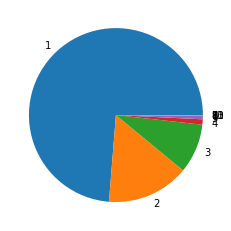

In [ ]:
# Gráficamente
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(7, 4))
plt.pie(resumenEtiquetas['count'], labels = resumenEtiquetas.index)
plt.show()

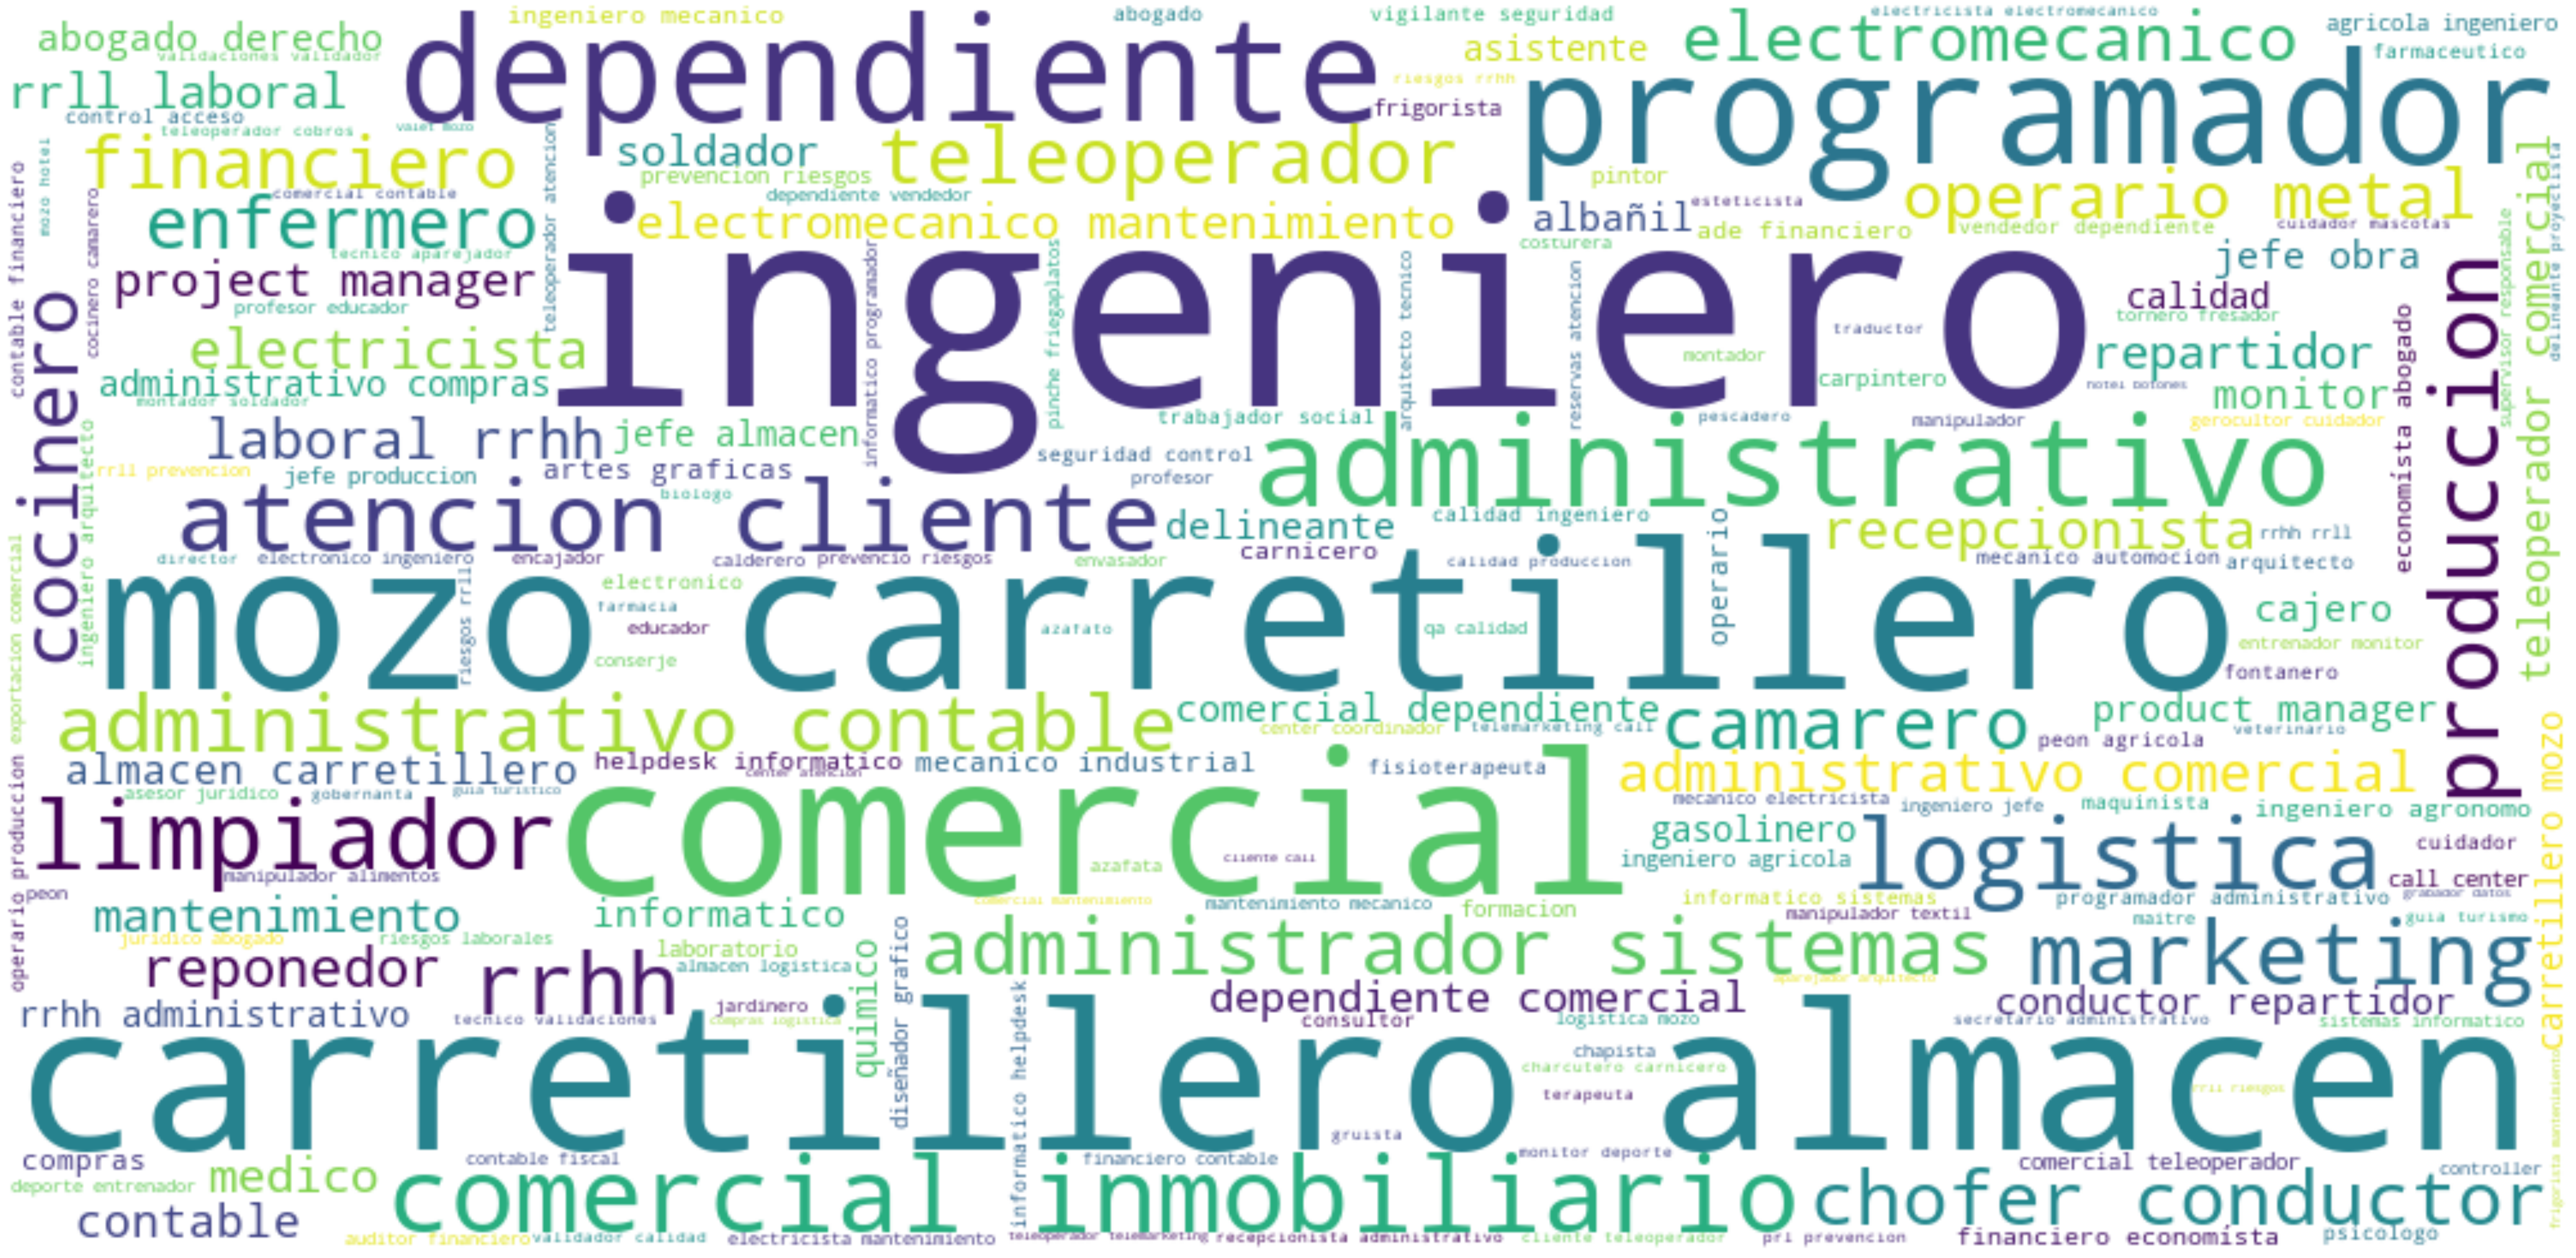

In [ ]:
#####################################
# ESTUDIO DE ETIQUETAS - FRECUENCIA #
#####################################
#import matplotlib.pyplot as plt

from wordcloud import WordCloud 

text=(" ").join(dfOriginal['label'])

nubePalabras = WordCloud(background_color='white', width = 1000, height = 500).generate(text)

plt.figure(figsize=(100,50))
plt.imshow(nubePalabras, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [ ]:
#######################################################
# EN DATAFRAME, CONVIERTE LABELS EN "ONE-HOT ENCODED" #
#######################################################

rows = []
for i, row in df.iterrows():
  new_row = {"text": row["text"]}
  row_labels = [0]*len(domain_labels)
  for label in row["labels"]: # Asigna más de una key si la tiene
    label_index = domain_labels.index(label)
    row_labels[label_index] = 1
  new_row['labels'] = row_labels
  rows.append(new_row)

df = pd.DataFrame(rows)

In [ ]:
#######################################################################
# DIVISIÓN ESTRATIFICADA (TRAIN/TEST/VALID) POR MUESTRA IMBALANCEADA  #
#######################################################################

from datasets import Dataset
datasetOriginal = Dataset.from_pandas(df)

import numpy as np
X = datasetOriginal['text']
X =list(map(lambda el:[el], X))
X =np.array(X)

y = datasetOriginal['labels']
y =np.array(y)

from datasets import DatasetDict
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(datasetOriginal['text'], datasetOriginal['labels'], stratify=datasetOriginal['labels'], shuffle=True, test_size= 0.2)
#X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.1)

from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.2)


import numpy as np
# Flatten list X
X_train = list(np.concatenate(X_train).flat)
X_test = list(np.concatenate(X_test).flat)


train = pd.DataFrame(list(zip(X_train, y_train)),
               columns =['text', 'labels'])

test = pd.DataFrame(list(zip(X_test, y_test)),
               columns =['text', 'labels'])


ds_train = Dataset.from_pandas(train)
ds_test = Dataset.from_pandas(test)

dataset = DatasetDict({
    'train': ds_train,
    'test': ds_test})

# Split the 20% test + valid in half test, half valid
# El 20% de test creado anteriormente, lo dividimos en dos para test y validación
test_valid = dataset['test'].train_test_split(test_size=0.5)


train_test_valid_dataset = DatasetDict({
    'train': dataset['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']}) 

· Oferta texto más corto: 2
"QA"

· Oferta texto más largo: 80
"Oficial de mantenimiento con experiencia en calderas, climatización y fontanería"

· Valor mediana: 38 (indicado para "padding")



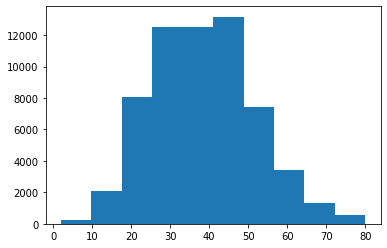

In [ ]:
###############################################
# ESTUDIO LONGITUD TEXTOS DEL CONJUNTO TRAIN  #
###############################################

# Estudio de la longitud de los textos del conjunto train
# para decidir el "padding" para el modelo:
#   Muy alto -> datos escasos
#   Muy bajo -> pérdida de información 

#import matplotlib.pyplot as plt

train_lens = [len(i) for i in train_test_valid_dataset['train']['text']]
plt.hist(train_lens)

# Valor de la mediana sería equilibrado
import statistics

minimoTrain = min(train_lens)
textoMinTrain = min(train_test_valid_dataset['train']['text'], key = len)

maximoTrain = max(train_lens)
textoMaxTrain = max(train_test_valid_dataset['train']['text'], key = len)

medianaTrain = int(statistics.median(train_lens))

print('· Oferta texto más corto: {}\n"{}"\n'.format(minimoTrain, textoMinTrain))
print('· Oferta texto más largo: {}\n"{}"\n'.format(maximoTrain, textoMaxTrain))
print('· Valor mediana: {} (indicado para "padding")\n'.format(medianaTrain))

In [ ]:
##########################
# MODELO - TOKENIZACIÓN  #
##########################

model_ckpt= "PlanTL-GOB-ES/roberta-base-bne"

# Vectorización
from transformers import AutoTokenizer

# para multi etiquetas, se tiene que especificar el tipo de clasificación
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, problem_type="multi_label_classification")

def tokenize_function(examples):
    # Mediana de la muestra train --> medianaTrain
    return tokenizer(examples["text"], padding="max_length", max_length= medianaTrain, truncation=True)

tokenized_datasets = train_test_valid_dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/957 [00:00<?, ?B/s]

  0%|          | 0/62 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [ ]:
# Conversión label IDs a floats

import torch
tokenized_datasets.set_format("torch")

tokenized_datasets = (tokenized_datasets
          .map(lambda x : {"float_labels": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_labels", "labels"))

  0%|          | 0/61284 [00:00<?, ?ex/s]

  0%|          | 0/7678 [00:00<?, ?ex/s]

  0%|          | 0/7677 [00:00<?, ?ex/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels=len(domain_labels)
# Especificamos aceleración GPU en Google Colab para que funcione ".to('cuda')"
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, problem_type="multi_label_classification").to('cuda')
#model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, problem_type="multi_label_classification")


Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.weight', 'classifie

In [ ]:
#############################################
# DEFINICIÓN DE MÉTRICAS PARA ENTRENAMIENTO #
#############################################

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import numpy as np
import torch

# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb 
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
# LONGFORMER (mejor pero más lento) - https://github.com/jlealtru/website_tutorials/blob/main/notebooks/Multi_label_classification_longformer_tutorial.ipynb
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
%cd '/content/gdrive/MyDrive/TFM'

/content/gdrive/MyDrive/TFM


In [ ]:
###############################
# PARÁMETROS DE ENTRENAMIENTO #
###############################

batch_size = 16
metric_name = "eval_loss"

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments("./TFM/modelos", 
                         learning_rate= 1.75e-5,
                          per_device_train_batch_size=batch_size,
                          per_device_eval_batch_size=batch_size,
                          num_train_epochs= 30,
                          weight_decay= 0.01, # antes 0.01,
                         load_best_model_at_end=True, 
                         save_strategy='epoch',
                         evaluation_strategy='epoch',
                         metric_for_best_model=metric_name)

trainer = Trainer(model=model, args=args, 
                  train_dataset=tokenized_datasets["train"], 
                  eval_dataset=tokenized_datasets["valid"], 
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# EJECUCIÓN DE ENTRENAMIENTO
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 61284
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 114930
  Number of trainable parameters = 124998606


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7677
  Batch size = 16
Saving model checkpoint to ./TFM/modelos/checkpoint-3831
Configuration saved in ./TFM/modelos/checkpoint-3831/config.json
Model weights saved in ./TFM/modelos/checkpoint-3831/pytorch_model.bin
tokenizer config file saved in ./TFM/modelos/checkpoint-3831/tokenizer_config.json
Special tokens file saved in ./TFM/modelos/checkpoint-3831/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examp

TrainOutput(global_step=22986, training_loss=0.003763260656119658, metrics={'train_runtime': 3764.2952, 'train_samples_per_second': 488.41, 'train_steps_per_second': 30.532, 'total_flos': 7210096806277440.0, 'train_loss': 0.003763260656119658, 'epoch': 6.0})

In [ ]:
# ALMACENAMIENTO DEL MODELO PARA UTILIZAR EN PRODUCCIÓN
trainer.save_model()

Saving model checkpoint to ./TFM/modelos
Configuration saved in ./TFM/modelos/config.json
Model weights saved in ./TFM/modelos/pytorch_model.bin
tokenizer config file saved in ./TFM/modelos/tokenizer_config.json
Special tokens file saved in ./TFM/modelos/special_tokens_map.json


In [ ]:
# EVALUACIÓN DEL MODEL CONTRA DATOS DE VALIDACIÓN
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 7677
  Batch size = 16


{'eval_loss': 0.005215533543378115,
 'eval_f1': 0.7211583862336708,
 'eval_roc_auc': 0.8197376694363885,
 'eval_accuracy': 0.6050540575745734,
 'eval_runtime': 27.1886,
 'eval_samples_per_second': 282.361,
 'eval_steps_per_second': 17.654,
 'epoch': 6.0}

In [ ]:
# FUNCIÓN DE PREDICCIÓN, CAPACIDAD MULTIETIQUETA

id2label = {idx:label for idx, label in enumerate(domain_labels)}
label2id = {label:idx for idx, label in enumerate(domain_labels)}

def predecirKeyword(text):
  encoding = tokenizer(text, return_tensors="pt")
  encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}
  outputs = trainer.model(**encoding)
  logits = outputs.logits
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(logits.squeeze().cpu())
  predictions = np.zeros(probs.shape)
  predictions[np.where(probs >= 0.1)] = 1 # ajustar theshold
  predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1]
  return predicted_labels

In [ ]:
# COMPROBACIÓN DE PREDICCIONES

comprobarTrain = pd.DataFrame (train_test_valid_dataset["test"], columns = ['text'])
comprobarTrain = pd.merge(comprobarTrain, dfOriginalLabels, how='inner')
comprobarTrain['prediction'] = comprobarTrain['text'].apply(predecirKeyword)
comprobarTrain.head(3)

text  \
0      ASESOR/A COMERCIAL PYMES 2.400€ (FIJO+INC)   
1                                     Head of SEO   
2  Vendedor/a Energías Renovables (Fotovoltaicas)   

                        labels              labels_str  numeroEtiquetas  \
0                  [comercial]               comercial                1   
1  [marketing, rrss, sem, seo]  marketing,rrss,sem,seo                4   
2                  [comercial]               comercial                1   

                                       prediction  
0                       [comercial, inmobiliario]  
1  [community-manager, marketing, rrss, sem, seo]  
2                        [comercial, dependiente]

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

y_true = MultiLabelBinarizer(classes=domain_labels).fit_transform(comprobarTrain['labels'])
y_pred = MultiLabelBinarizer(classes=domain_labels).fit_transform(comprobarTrain['prediction'])

In [ ]:
##################################
# VERIFICACIÓN AJUSTE DEL MODELO #
##################################

from sklearn.metrics import confusion_matrix
from sklearn import metrics

print(metrics.classification_report(y_true, 
                                    y_pred, 
                                    target_names= domain_labels))

                                        precision    recall  f1-score   support

                               abogado       0.56      0.66      0.60        98
                            acomodador       0.00      0.00      0.00         1
                                 actor       0.00      0.00      0.00         2
                             acupuntor       0.00      0.00      0.00         0
                                   ade       0.16      0.33      0.22        30
                           adiestrador       1.00      1.00      1.00         4
               administracion-empresas       0.00      0.00      0.00         1
                  administrador-fincas       0.00      0.00      0.00         1
                administrador-sistemas       0.36      0.70      0.48       116
                        administrativo       0.64      0.95      0.76       547
           administrativo-discapacidad       0.00      0.00      0.00         0
                            aeropuerto 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
